In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
import matplotlib.pyplot as plt
import numpy as np

from torch.autograd import Variable

### Creating config object (argparse workaround)

In [2]:
class Config:
    pass

config = Config()
config.mnist_path = None
config.batch_size = 16
config.num_workers = 3
config.num_epochs = 10
config.noise_size = 50
config.print_freq = 100


### Create dataloder

In [3]:
train = torchvision.datasets.FashionMNIST("fashion_mnist", train=True, transform=torchvision.transforms.ToTensor(), download=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting fashion_mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fashion_mnist/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting fashion_mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fashion_mnist/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting fashion_mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fashion_mnist/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting fashion_mnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fashion_mnist/FashionMNIST/raw



In [4]:
dataloader = DataLoader(train, batch_size=16, shuffle=True)

In [5]:
len(dataloader)

3750

In [6]:
for image, cat in dataloader:
    break

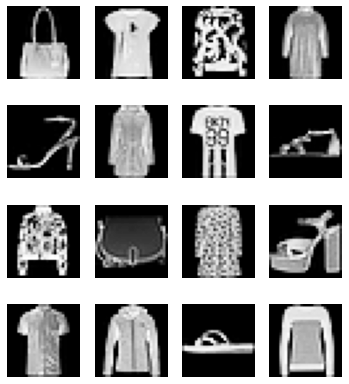

In [7]:
plt.figure(figsize=(6, 7))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(image[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.xlabel(cat[i])
    plt.axis('off')

In [8]:
cat

tensor([8, 6, 2, 2, 5, 4, 0, 5, 4, 8, 3, 5, 6, 4, 5, 2])

In [9]:
image.size()

torch.Size([16, 1, 28, 28])

In [10]:
28*28

784

### Create generator and discriminator

In [11]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential( 
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())
        
    def forward(self, x):
        return self.model(x)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1), 
            nn.Sigmoid())
    def forward(self, x):
        return self.model(x)

In [12]:
generator = Generator()
discriminator = Discriminator()

### Задание

1) Модифицируйте код и реализуйте [Wasserstein GAN](https://arxiv.org/abs/1701.07875) ([From GAN to WGAN
](https://lilianweng.github.io/posts/2017-08-20-gan/)) используя weight clipping. (1 балл)

2) Замените  weight clipping на [gradient penalty](https://arxiv.org/pdf/1704.00028v3.pdf). (1 балл)

3) Добавьте к обучению WGAN условие на метку, продемонстрируйте [условную генерацию](https://arxiv.org/pdf/1411.1784.pdf).  (1 балл) 

Напишите отчет о том, что попробовали, какие результаты получили, какую архитектуру использовали, как вам кажется надо обучать GAN, чтобы добиться сходимости? Каждый пункт обязательно сопроводите визуализациями.

### train_function

In [13]:
from IPython.display import clear_output

In [14]:

def train_gan(discriminator, generator, config):
    optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
    optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

    criterion = nn.BCELoss()
    ERRD_x = np.zeros(config.num_epochs)
    ERRD_z = np.zeros(config.num_epochs)
    ERRG = np.zeros(config.num_epochs)
    N = len(dataloader)
    input = Variable(torch.FloatTensor(config.batch_size, 28*28))
    noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
    fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
    label = Variable(torch.zeros((config.batch_size, 1)))
    real_label = 1
    fake_label = 0

    errD_x_epochs, errD_z_epochs, errG_epochs = [], [], []
    glob_iter = 0

    for epoch in range(config.num_epochs):
        for iteration, (images, cat) in enumerate(dataloader):
            clear_output(True)
            ####### 
            # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z))) 
            #######
            discriminator.zero_grad()
        
            # real
            label.data.fill_(real_label)
            input_data = images.view(images.shape[0], -1)
            output = discriminator(input_data)
            errD_x = criterion(output, label)
            ERRD_x[epoch] += errD_x.item()
            errD_x.backward()
        
            # fake 
            noise.data.normal_(0, 1)
            fake = generator(noise)
            label.data.fill_(fake_label)
            output = discriminator(fake.detach())
            errD_z = criterion(output, label)
            ERRD_z[epoch] += errD_z.item()
            errD_z.backward()
        
            optim_D.step()
        
            ####### 
            # Generator stage: maximize log(D(G(x))
            #######
            generator.zero_grad()
            label.data.fill_(real_label)
            output = discriminator(fake)
            errG = criterion(output, label)
            ERRG[epoch] += errG.item()
            errG.backward()

            optim_G.step()
            glob_iter += 1

            if (iteration+1) % config.print_freq == 0:
                errD_x_epochs.append(errD_x.item())
                errD_z_epochs.append(errD_z.item())
                errG_epochs.append(errG.item())
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 3, 1)
                plt.plot(errG_epochs, label='errG')
                plt.xlabel('iter', fontsize=16)
                plt.ylabel('err', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid()
                plt.subplot(1, 2, 2)
                plt.plot(errD_x_epochs, label='errD_x')
                plt.plot(errD_z_epochs, label='errD_z')
                plt.xlabel('iter', fontsize=16)
                plt.ylabel('err', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid()
                plt.show()
                print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1, 
                                                                                            errD_x.item(),
                                                                                            errD_z.item(), 
                                                                                            errG.item()))
        

### Vanilla GAN

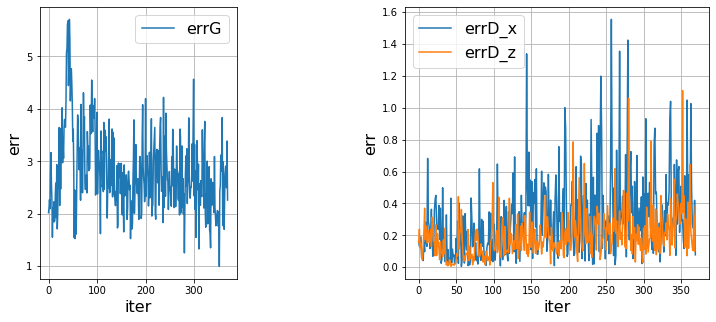

Epoch:10 Iter: 3700 errD_x: 0.08 errD_z: 0.38 errG: 2.26


In [15]:
train_gan(discriminator, generator, config)

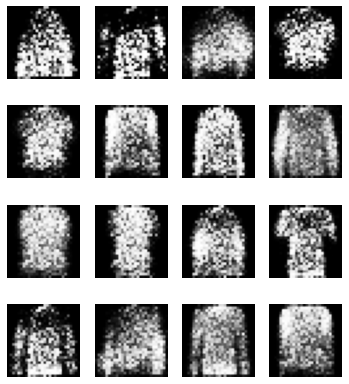

In [16]:
noise = Variable(torch.Float  Tensor(config.batch_size, config.noise_size))
noise.data.normal_(0, 1)
fake = generator(noise)
plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

### WGAN clipping

In [17]:
def train_wgan(discriminator, generator, config, lipschitz='clipping', c=0.01):
    optim_G = optim.RMSprop(params=generator.parameters(), lr=0.0001)
    optim_D = optim.RMSprop(params=discriminator.parameters(), lr=0.0001)

    criterion = nn.BCELoss()
    ERRD_x = np.zeros(config.num_epochs)
    ERRD_z = np.zeros(config.num_epochs)
    ERRG = np.zeros(config.num_epochs)
    N = len(dataloader)
    input = Variable(torch.FloatTensor(config.batch_size, 28*28))
    noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
    fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
    label = Variable(torch.zeros((config.batch_size, 1)))
    real_label = 1
    fake_label = 0

    errD_x_epochs, errD_z_epochs, errG_epochs = [], [], []
    glob_iter = 0

    for epoch in range(config.num_epochs):
        for iteration, (images, cat) in enumerate(dataloader):
            clear_output(True)
            ####### 
            # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z))) 
            #######
            discriminator.zero_grad()
        
            # real
            label.data.fill_(real_label)
            input_data = images.view(images.shape[0], -1)
            output = discriminator(input_data)
            errD_x = criterion(output, label)
            ERRD_x[epoch] += errD_x.item()
            errD_x.backward()
        
            # fake 
            noise.data.normal_(0, 1)
            fake = generator(noise)
            label.data.fill_(fake_label)
            output = discriminator(fake.detach())
            errD_z = criterion(output, label)
            ERRD_z[epoch] += errD_z.item()
            errD_z.backward()
        
            optim_D.step()

            #weight_clipping
            if lipschitz == 'clipping':
                for param in discriminator.parameters():
                    param.data.clamp_(-c, c)
        
            ####### 
            # Generator stage: maximize log(D(G(x))
            #######
            generator.zero_grad()
            label.data.fill_(real_label)
            output = discriminator(fake)
            errG = criterion(output, label)
            ERRG[epoch] += errG.item()
            errG.backward()

            optim_G.step()
            glob_iter += 1

            if (iteration+1) % config.print_freq == 0:
                errD_x_epochs.append(errD_x.item())
                errD_z_epochs.append(errD_z.item())
                errG_epochs.append(errG.item())
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 3, 1)
                plt.plot(errG_epochs, label='errG')
                plt.xlabel('iter', fontsize=16)
                plt.ylabel('err', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid()
                plt.subplot(1, 2, 2)
                plt.plot(errD_x_epochs, label='errD_x')
                plt.plot(errD_z_epochs, label='errD_z')
                plt.xlabel('iter', fontsize=16)
                plt.ylabel('err', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid()
                plt.show()
                print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1, 
                                                                                            errD_x.item(),
                                                                                            errD_z.item(), 
                                                                                            errG.item()))

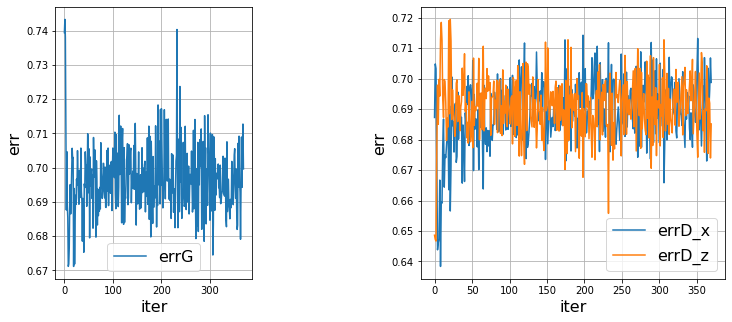

Epoch:10 Iter: 3700 errD_x: 0.70 errD_z: 0.69 errG: 0.70


In [18]:
generator_clipping = Generator()
discriminator_clipping = Discriminator()
train_wgan(discriminator_clipping, generator_clipping, config, lipschitz='clipping')

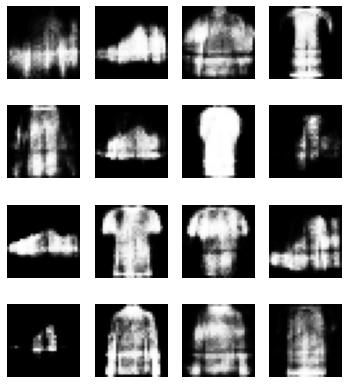

In [19]:
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
noise.data.normal_(0, 1)
fake = generator_clipping(noise)

plt.figure(figsize=(6, 7))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

### WGAN gradient penalty

In [20]:
from torch import autograd

In [21]:
def train_wgan_gp(discriminator, generator, config, penalty_param=10):
    optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
    optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

    criterion = nn.BCELoss()
    ERRD_x = np.zeros(config.num_epochs)
    ERRD_z = np.zeros(config.num_epochs)
    ERRG = np.zeros(config.num_epochs)
    N = len(dataloader)
    input = Variable(torch.FloatTensor(config.batch_size, 28*28))
    noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
    fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
    label = Variable(torch.zeros((config.batch_size, 1)))
    real_label = 1
    fake_label = 0

    errD_x_epochs, errD_z_epochs, errG_epochs = [], [], []
    glob_iter = 0

    for epoch in range(config.num_epochs):
        for iteration, (images, cat) in enumerate(dataloader):
            clear_output(True)
            ####### 
            # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z))) 
            #######
            discriminator.zero_grad()
        
            # real
            label.data.fill_(real_label)
            input_data = images.view(images.shape[0], -1)
            output = discriminator(input_data)
            errD_x = criterion(output, label)
            ERRD_x[epoch] += errD_x.item()
            errD_x.backward()
        
            # fake 
            noise.data.normal_(0, 1)
            fake = generator(noise)
            label.data.fill_(fake_label)
            output = discriminator(fake.detach())
            errD_z = criterion(output, label)
            ERRD_z[epoch] += errD_z.item()
            errD_z.backward()
        
            optim_D.step()

            #gradient_penalty: add to objective λ(||∇D(x_hat)||_2 - 1)^2; x_hat = εx_real + (1-ε)x_fake
            batch_size = input_data.size(0)
            epsilon = torch.rand(batch_size, 1)
            epsilon = epsilon.expand_as(input_data)

            x_hat = epsilon * input_data + (1 - epsilon) * fake
            x_hat_output = discriminator(x_hat)

            gradients = autograd.grad(
                            outputs=x_hat_output,
                            inputs=x_hat,
                            grad_outputs=torch.ones_like(x_hat_output),
                            create_graph=True,
                            retain_graph=True,
                        )[0]
            gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * penalty_param
            gradient_penalty.backward(retain_graph=True)
            
        
            ####### 
            # Generator stage: maximize log(D(G(x))
            #######
            generator.zero_grad()
            label.data.fill_(real_label)
            output = discriminator(fake)
            errG = criterion(output, label)
            ERRG[epoch] += errG.item()
            errG.backward()

            optim_G.step()
            glob_iter += 1

            if (iteration+1) % config.print_freq == 0:
                errD_x_epochs.append(errD_x.item())
                errD_z_epochs.append(errD_z.item())
                errG_epochs.append(errG.item())
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 3, 1)
                plt.plot(errG_epochs, label='errG')
                plt.xlabel('iter', fontsize=16)
                plt.ylabel('err', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid()
                plt.subplot(1, 2, 2)
                plt.plot(errD_x_epochs, label='errD_x')
                plt.plot(errD_z_epochs, label='errD_z')
                plt.xlabel('iter', fontsize=16)
                plt.ylabel('err', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid()
                plt.show()
                print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1, 
                                                                                            errD_x.item(),
                                                                                            errD_z.item(), 
                                                                                            errG.item()))


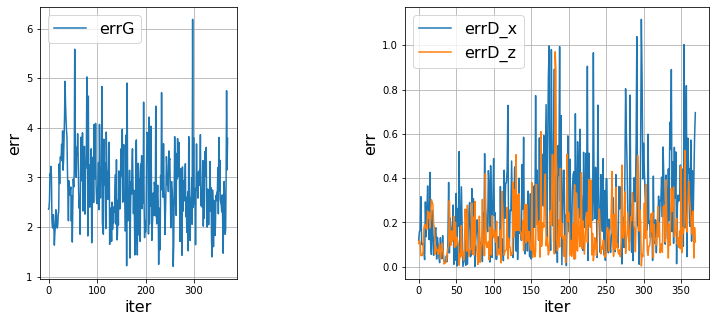

Epoch:10 Iter: 3700 errD_x: 0.70 errD_z: 0.11 errG: 3.78


In [22]:
generator_gp = Generator()
discriminator_gp= Discriminator()
train_wgan_gp(discriminator_gp, generator_gp, config)

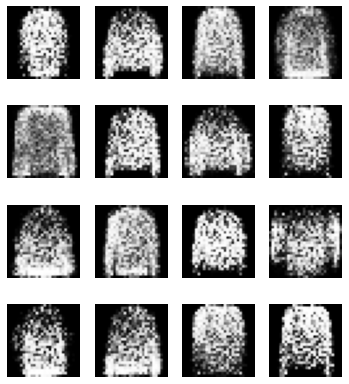

In [23]:
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
noise.data.normal_(0, 1)
fake = generator_gp(noise)

plt.figure(figsize=(6, 7))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

### Comparasion

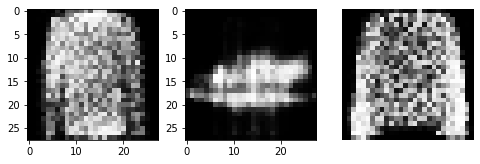

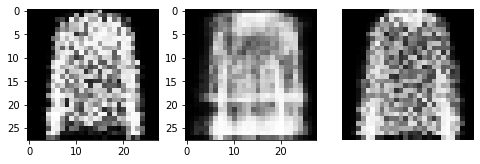

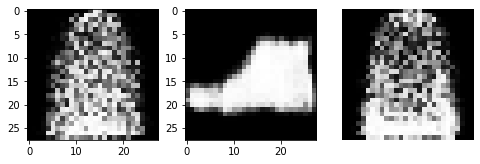

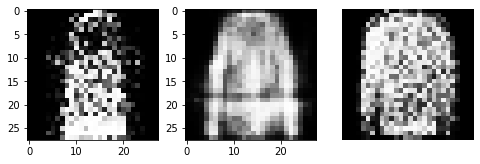

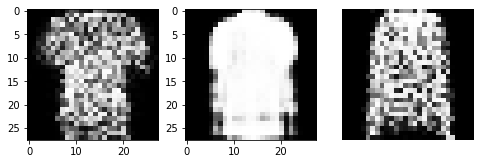

In [24]:
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
noise.data.normal_(0, 1)

fake = generator(noise)
fake_clipping = generator_clipping(noise)
fake_gp = generator_gp(noise)



for i in range(5):
    plt.figure(figsize=(8, 10))
    plt.subplot(1, 3, 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.subplot(1, 3, 2)
    plt.imshow(fake_clipping[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.subplot(1, 3, 3)
    plt.imshow(fake_gp[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')


### Conditional GAN

In [25]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.label_embedding = nn.Embedding(10, 10)
        self.model = nn.Sequential( 
            nn.Linear(config.noise_size+10, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())
        
    def forward(self, x, labels):
        x = torch.cat([x, self.label_embedding(labels)], 1)
        return self.model(x)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.label_embedding = nn.Embedding(10, 10)
        self.model = nn.Sequential(
            nn.Linear(28*28+10, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1), 
            nn.Sigmoid())
    def forward(self, x, labels):
        x = torch.cat([x, self.label_embedding(labels)], 1)
        return self.model(x)

In [26]:
from tqdm.notebook import tqdm_notebook

In [27]:
from IPython.display import clear_output

In [28]:

def train_cgan(discriminator, generator, config):
    optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
    optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

    criterion = nn.BCELoss()
    ERRD_x = np.zeros(config.num_epochs)
    ERRD_z = np.zeros(config.num_epochs)
    ERRG = np.zeros(config.num_epochs)
    N = len(dataloader)
    input = Variable(torch.FloatTensor(config.batch_size, 28*28))
    noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
    fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
    label = Variable(torch.zeros((config.batch_size, 1)))
    real_label = 1
    fake_label = 0

    errD_x_epochs, errD_z_epochs, errG_epochs = [], [], []
    glob_iter = 0

    for epoch in range(config.num_epochs):
        for iteration, (images, cat) in enumerate(dataloader):
            clear_output(True)
            ####### 
            # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z))) 
            #######
            discriminator.zero_grad()
        
            # real
            label.data.fill_(real_label)
            input_data = images.view(images.shape[0], -1)
            output = discriminator(input_data, cat)
            errD_x = criterion(output, label)
            ERRD_x[epoch] += errD_x.item()
            errD_x.backward()

            # fake 
            fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, 16)))
            noise.data.normal_(0, 1)
            fake = generator(noise, fake_labels)
            label.data.fill_(fake_label)
            output = discriminator(fake.detach(), fake_labels)
            errD_z = criterion(output, label)
            ERRD_z[epoch] += errD_z.item()
            errD_z.backward()
        
            optim_D.step()
            ####### 
            # Generator stage: maximize log(D(G(x))
            #######
            generator.zero_grad()
            label.data.fill_(real_label)
            output = discriminator(fake, fake_labels)
            errG = criterion(output, label)
            ERRG[epoch] += errG.item()
            errG.backward()

            optim_G.step()
            glob_iter += 1
            if (iteration+1) % config.print_freq == 0:
                errD_x_epochs.append(errD_x.item())
                errD_z_epochs.append(errD_z.item())
                errG_epochs.append(errG.item())
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 3, 1)
                plt.plot(errG_epochs, label='errG')
                plt.xlabel('iter', fontsize=16)
                plt.ylabel('err', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid()
                plt.subplot(1, 2, 2)
                plt.plot(errD_x_epochs, label='errD_x')
                plt.plot(errD_z_epochs, label='errD_z')
                plt.xlabel('iter', fontsize=16)
                plt.ylabel('err', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid()
                plt.show()
                print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1, 
                                                                                            errD_x.item(),
                                                                                            errD_z.item(), 
                                                                                            errG.item()))
        
        

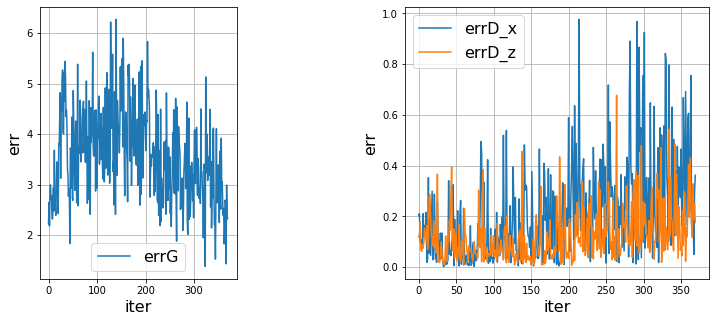

Epoch:10 Iter: 3700 errD_x: 0.36 errD_z: 0.18 errG: 2.32


In [29]:
generator_cgan = Generator()
discriminator_cgan = Discriminator()
train_cgan(discriminator_cgan, generator_cgan, config)

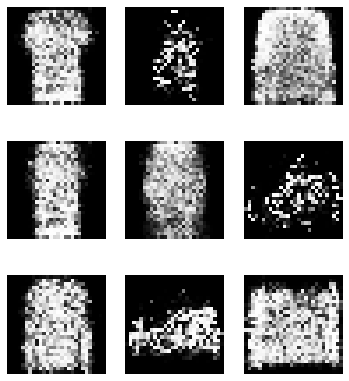

In [30]:
plt.figure(figsize=(6, 7))
for i in range(9):
    noise_test = Variable(torch.FloatTensor(1, config.noise_size))
    noise_test.data.normal_(0, 1)
    fake = generator_cgan(noise_test, torch.tensor([i]))
    plt.subplot(3, 3, i + 1)
    plt.imshow(fake[0].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

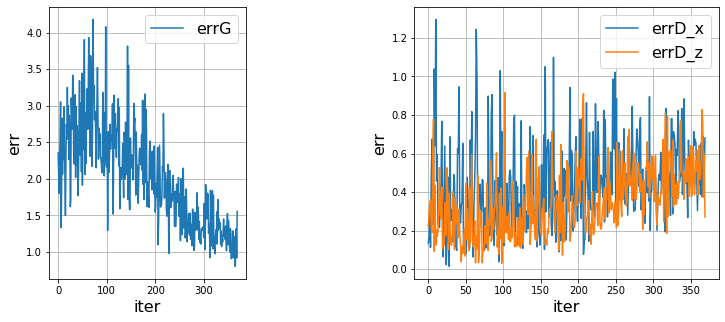

Epoch:10 Iter: 3700 errD_x: 0.68 errD_z: 0.27 errG: 1.55


In [31]:
train_cgan(discriminator_cgan, generator_cgan, config)

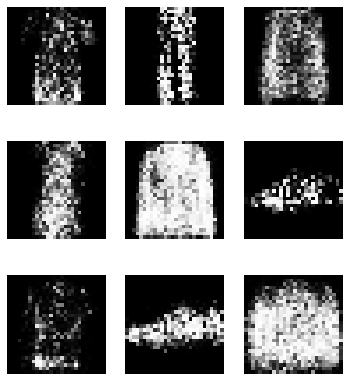

In [32]:
plt.figure(figsize=(6, 7))
for i in range(9):
    noise_test = Variable(torch.FloatTensor(1, config.noise_size))
    noise_test.data.normal_(0, 1)
    fake = generator_cgan(noise_test, torch.tensor([i]))
    plt.subplot(3, 3, i + 1)
    plt.imshow(fake[0].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')